# Predicting Concrete Strength with Neural Networks
DAT300, group CA2-10. Jon Nordby and Espen Sønneland.


## Kaggle setup
Downloads data from https://www.kaggle.com/c/dat300-2018-concrete

In [1]:
!pip install kaggle

In [2]:
import io, os

import googleapiclient.discovery
import googleapiclient.http
import google.colab

def colab_kaggle_install_apikey():
  """ 
  Copies 'kaggle.json' from Google Drive to Colaboratory environment
  
  Based on https://medium.com/@move37timm/using-kaggle-api-for-google-colaboratory-d18645f93648
  """
  
  google.colab.auth.authenticate_user()

  drive_service = googleapiclient.discovery.build('drive', 'v3')
  results = drive_service.files().list(q="name = 'kaggle.json'", fields="files(id)").execute()
  kaggle_api_key = results.get('files', [])
  if len(kaggle_api_key) == 0:
    raise ValueError("Could not find kaggle.json in Google Drive")

  filename = "/root/.kaggle/kaggle.json"
  os.makedirs(os.path.dirname(filename), exist_ok=True)

  request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
  fh = io.FileIO(filename, 'wb')
  downloader = googleapiclient.http.MediaIoBaseDownload(fh, request)
  done = False
  while done is False:
      status, done = downloader.next_chunk()
  os.chmod(filename, 600)
  print('Installed to {}'.format(filename))
  
colab_kaggle_install_apikey()

Installed to /root/.kaggle/kaggle.json


In [3]:
!kaggle competitions download -c dat300-2018-concrete -p data/

Concrete_sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
Concrete_test.csv: Skipping, found more recently modified local copy (use --force to force download)
Concrete_train.csv: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import time

import pandas
import numpy
import matplotlib.pyplot as plt

import sklearn

import sklearn.preprocessing
import sklearn.model_selection
import sklearn.pipeline

import sklearn.linear_model
import sklearn.ensemble
import sklearn.svm

import keras
import keras.wrappers.scikit_learn

In [5]:
dataset = pandas.read_csv('data/Concrete_train.csv')
target_column = 'ConcreteCompressiveStrength'
feature_columns = list(set(dataset.columns) - set([target_column]))

dataset.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,ConcreteCompressiveStrength
0,525.000000,0.000000,0.000000,189.000000,0.0,1125.000000,613.000000,7,42.419998
1,276.000000,116.000000,90.000000,180.000000,9.0,870.000000,768.000000,28,44.279999
2,182.000000,45.200001,122.000000,170.199997,8.2,1059.400024,780.700012,100,48.669998
3,212.600006,0.000000,100.400002,159.399994,10.4,1003.799988,903.799988,100,47.740002
4,251.399994,0.000000,118.300003,188.500000,6.4,1028.400024,757.700012,100,44.209999


In [8]:
dataset.describe() 
 

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,ConcreteCompressiveStrength
count,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000
mean,277.400416,77.038835,56.515395,182.490569,6.051040,971.709986,770.042163,44.049931,35.321817
std,104.586506,87.651090,65.031169,20.920979,5.660229,77.788102,80.282289,60.614426,16.706825
min,102.000000,0.000000,0.000000,121.800003,0.000000,801.000000,594.000000,1.000000,2.330000
25%,190.000000,0.000000,0.000000,167.000000,0.000000,932.000000,724.299988,7.000000,22.950001
50%,254.000000,24.000000,0.000000,185.699997,6.100000,968.000000,776.400024,28.000000,33.950001
75%,349.000000,145.000000,118.300003,192.000000,10.000000,1028.400024,821.000000,56.000000,45.080002
max,540.000000,359.399994,200.100006,247.000000,32.200001,1145.000000,992.599976,365.000000,82.599998


## Create models for comparisons

Baseline estimators from scikit-learn. Neural Networks using Keras with Tensorflow backend, using the scikit-learn estimator wrapper to have a compatible interface.

In [130]:

def train_evaluate_model(X, Y, model, gridparams, gridcv=5, evalcv=5, test_size=0.3, rng=1):
  
    scoring = 'neg_mean_absolute_error'
    metric = sklearn.metrics.mean_absolute_error
  
    X_train, X_test, Y_train, Y_test = \
      sklearn.model_selection.train_test_split(X, Y, test_size=test_size, random_state=rng)
    
 
    # Find hyperparameters
    train_start = time.time()

    estimator = model
    if gridparams is None:
      details = None
    else:
      grid = sklearn.model_selection.GridSearchCV(model, gridparams, cv=gridcv, scoring=scoring,
                                                  iid=False, refit=False, return_train_score=True)
      grid.fit(X_train, Y_train)
      details = grid.cv_results_ 
      estimator.set_params(**grid.best_params_)


    # Fit with all training data
    history = estimator.fit(X_train, Y_train)
    if not getattr(history, 'history', None):
      history = None # only want the Keras History instances

    train_time = time.time() - train_start
    
    # Evaluate   
    evaluate_start = time.time()
    train_score = metric(Y_train, estimator.predict(X_train))
    test_score = metric(Y_test, estimator.predict(X_test))
    evaluate_time =  time.time() - evaluate_start
    
    return test_score, history, details, train_time, evaluate_time, train_score, estimator

def build_mlp(layer_sizes, activation='relu'):
    Dense = keras.layers.Dense
  
    model = keras.Sequential()
    for i, size in enumerate(layer_sizes):
      params = dict(activation=activation)
      if i == 0:
        params['input_dim'] = 8
      model.add(Dense(size, **params))
      #print('i', size, i, params)
    model.add(Dense(1))
    
    optimizer = keras.optimizers.Adam(lr=0.001*5.0)
    
    model.compile(loss='mean_absolute_error', optimizer=optimizer)
    
    return model

def KerasMLP(layer_sizes, activation):
  def build_func():
    return build_mlp(layer_sizes, activation)
  
  early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                             min_delta=0.0, patience=50, verbose=0,
                                             mode='auto', baseline=None,
                                             restore_best_weights=True)

  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.33,
                              patience=20, min_lr=0.0001, verbose=0)
  
  Wrapper = keras.wrappers.scikit_learn.KerasRegressor  
  w = Wrapper(build_func, epochs=500, batch_size=50,
              callbacks=[reduce_lr], validation_split=0.25, verbose=0)
  return w
  
def PolyRidge(degree):
    m = sklearn.pipeline.make_pipeline(
      sklearn.preprocessing.PolynomialFeatures(degree),
      sklearn.linear_model.Ridge(),
    )
    return m
 
A_params = numpy.geomspace(0.001, 1000.0, 20)
C_params = numpy.geomspace(0.1, 1000.0, 12)
gamma_params = numpy.geomspace(0.01, 10.0, 12)

models = {
    'RandomForest': ( sklearn.ensemble.RandomForestRegressor(n_estimators=50),
                     {'max_depth': numpy.linspace(3, 50, 20)}),
    
    'MLP 64-32-16 tanh': ( KerasMLP([64,32,16],'tanh'), None ),
    
    #'MLP 16-8-4 Relu': ( KerasMLP([16,8,4],'relu'), None ),
    #'MLP 32-16-8 Relu': ( KerasMLP([32,16,8],'relu'), None ),
    'MLP 64-32-16 Relu': ( KerasMLP([64,32,16],'relu'), None ),
    #'MLP 128-64-32 Relu': ( KerasMLP([128,64,32],'relu'), None ),
    #'MLP 258-128-64 Relu': ( KerasMLP([256,128,64],'relu'), None ),
    'MLP 512-258-128 Relu': ( KerasMLP([512,256,128],'relu'), None ),
    'MLP 1024-512-256 Relu': ( KerasMLP([1024,512,256],'relu'), None ),
    'MLP 2048-1024-512 Relu': ( KerasMLP([2048,1024,512],'relu'), None ),
    
    'MLP 1024-512-256-64 Relu': ( KerasMLP([1024,512,256,64],'relu'), None ),

    #'MLP wide 512-128 Relu': ( KerasMLP([512,128],'relu'), None ),
    #'MLP wide 1024-128 Relu': ( KerasMLP([1024,128],'relu'), None ),
    #'MLP wide 2048-256 Relu': ( KerasMLP([2048,256],'relu'), None ),
    #'MLP wide 2048-256 tanh': ( KerasMLP([2048,256],'tanh'), None ),

    #'MLP deep 128-128-128-32 Relu': ( KerasMLP([128,128,128,32],'relu'), None ),
    #'MLP deep 256-256-256-64 Relu': ( KerasMLP([256,256,256,64],'relu'), None ),

    'Poly4-Ridge': ( PolyRidge(4) , { 'ridge__alpha': A_params }),
    'Poly3-Ridge': ( PolyRidge(3) , { 'ridge__alpha': A_params }),
    'Poly2-Ridge': ( PolyRidge(2) , { 'ridge__alpha': A_params }),
    'Poly1-Ridge': ( PolyRidge(1) , { 'ridge__alpha': A_params }),
    
     # XXX: SVM, kernel=poly freezes when passing gamma
    'SVM linear': ( sklearn.svm.SVR(kernel='linear'), { 'C': C_params } ),
    'SVM poly3': ( sklearn.svm.SVR(kernel='poly', degree=3), { 'C': C_params } ),
    'SVM rbf': ( sklearn.svm.SVR(kernel='rbf'), { 'C': C_params, 'gamma': gamma_params } ),
}

scaler = sklearn.preprocessing.StandardScaler()
X = scaler.fit_transform(dataset[feature_columns])
Y = dataset[target_column].values

results = {}
for i, model in enumerate(models.items()):
    name, values = model
    estimator, params = values
    print('training {}...'.format(name), end='')
    r = train_evaluate_model(X, Y, estimator, params)
    assert len(r) == 7, len(r)
    print('took {:1f} seconds. Test score: {:2f}'.format(r[3]+r[4], r[0]))
    results[name] = r

training RandomForest...took 11.035164 seconds. Test score: 4.241193
training MLP 64-32-16 tanh...took 35.818386 seconds. Test score: 4.450910
training MLP 64-32-16 Relu...took 35.861743 seconds. Test score: 4.406305
training MLP 512-258-128 Relu...took 55.518952 seconds. Test score: 4.023252
training MLP 1024-512-256 Relu...took 101.675818 seconds. Test score: 3.654873
training MLP 2048-1024-512 Relu...took 267.830899 seconds. Test score: 3.731886
training MLP 1024-512-256-64 Relu...took 104.819233 seconds. Test score: 3.679037
training Poly4-Ridge...took 6.462159 seconds. Test score: 6.259076
training Poly3-Ridge...took 2.131347 seconds. Test score: 5.433845
training Poly2-Ridge...took 0.699401 seconds. Test score: 6.678878
training Poly1-Ridge...took 0.319804 seconds. Test score: 8.676622
training SVM linear...took 20.341797 seconds. Test score: 9.253163
training SVM poly3...took 21.690072 seconds. Test score: 6.913316
training SVM rbf...took 31.874187 seconds. Test score: 4.604682


## Plot learning progress of Neural Network

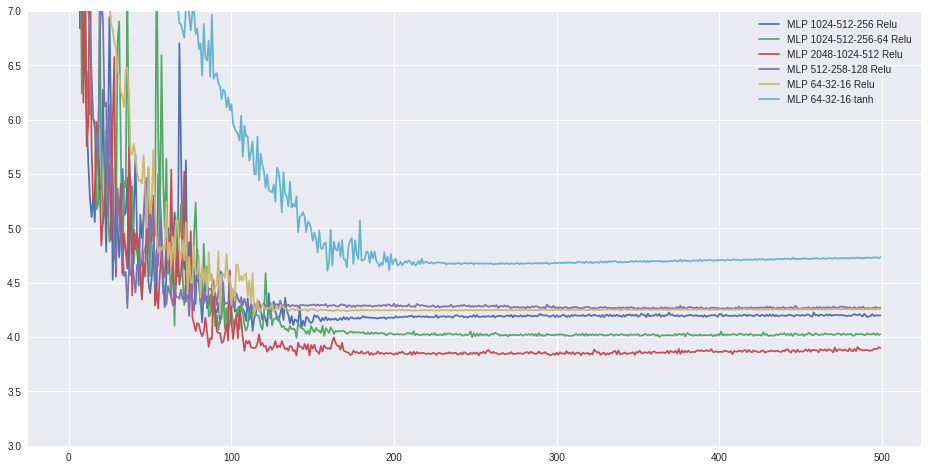

In [132]:
val = { n : r[1].history['val_loss'] for n,r in results.items() if r[1] }
def pad_to(length, v):
  a = numpy.full(length, numpy.nan)
  a[0:len(v)] = v
  return a

longest = max([ len(v) for v in val.values() ])
val = { k: pad_to(longest, v) for k,v in val.items() }
val = pandas.DataFrame(val)
val.plot(figsize=(16, 8), ylim=(3,7))

Using `tanh` instead of `ReLu` activation converges significantly slower, and thus performs worse with same amount of training time. For that  reason we focus on *ReLu*.

# Summary of results

In [133]:
def selected(r):
  # return a dictionary of data about the model selected by GridSearchCV
  cv_results = r[2]
  if cv_results is None:
    return {}
  df = pandas.DataFrame(cv_results)
  s = df.sort_values('rank_test_score', ascending=True)
  s = s.to_dict('rows')[0]
  return s

df = pandas.DataFrame({
    'model': list(results.keys()),
    'test_score': [ r[0] for r in results.values() ],
    'train_score': [ r[5] for r in results.values() ],
    'train_time': [ r[3] for r in results.values() ],
    'predict_time': [ r[4] for r in results.values() ],
    'params': [ selected(r).get('params', {}) for r in results.values() ],
})
df.sort_values(by='test_score', ascending=True)

,model,params,predict_time,test_score,train_score,train_time
4,MLP 1024-512-256 Relu,{},3.632936,3.654873,1.628134,98.042882
6,MLP 1024-512-256-64 Relu,{},3.708816,3.679037,1.587300,101.110417
5,MLP 2048-1024-512 Relu,{},3.762365,3.731886,1.592286,264.068533
3,MLP 512-258-128 Relu,{},3.562694,4.023252,2.049588,51.956258
0,RandomForest,{'max_depth': 37.631578947368425},0.009444,4.241193,1.619001,11.025720
2,MLP 64-32-16 Relu,{},3.519528,4.406305,2.826139,32.342215
1,MLP 64-32-16 tanh,{},3.459194,4.450910,2.454563,32.359193
13,SVM rbf,"{'C': 432.87612810830615, 'gamma': 0.065793322...",0.012139,4.604682,2.474714,31.862048
8,Poly3-Ridge,{'ridge__alpha': 1.438449888287663},0.012279,5.433845,3.157740,2.119068
7,Poly4-Ridge,{'ridge__alpha': 26.366508987303554},0.019643,6.259076,2.819240,6.442516


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


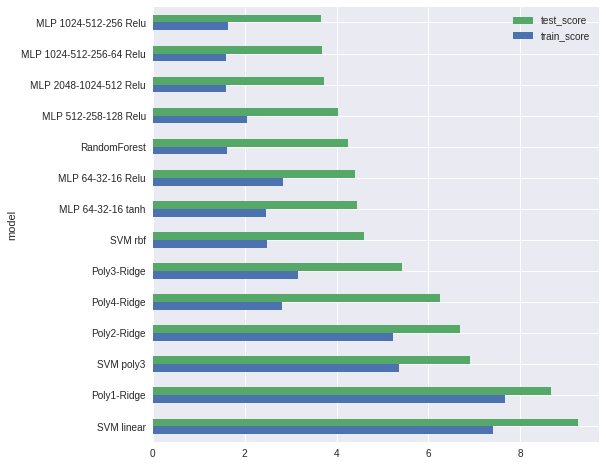

In [134]:
desc = df.sort_values(by='test_score', ascending=False)
desc.plot(kind='barh',x='model', y=['train_score', 'test_score'], legend='reverse', figsize=(8,8))

The baseline non-linear estimators RandomForest and SVM RBF got Mean-Absolute-Error (MAE) results of 4.2-4.6. Ridge linear regression on Polynomial features were unable to go under MAE 5.0.  Pure linear models were unable to get under MAE 8.0. This suggest quite complex non-linear relationships between concrete strength and the contents of the concrete.

Generally bigger Neural Networks perform better. Both adding additional layers in depth, and increasing the size of layers increase the ability to represent the non-linearities of the system.

We were suprised by the number of neurons needed, especially considering that we only have 8 features. And that we were able to successfully train networks with over 1 million weights with only 900 instances in our dataset.

To reach MAE 3.6-3.7 with the Neural Networks, a critical addition was to use `ReduceLROnPlateau` to reduce learning rate. Before this, the learning progress was chaotic and noisy after epoch 100 (seemingly regardless of hyperparameters), and it was hard to get below MAE 4.0.

## Accuracy versus inference time

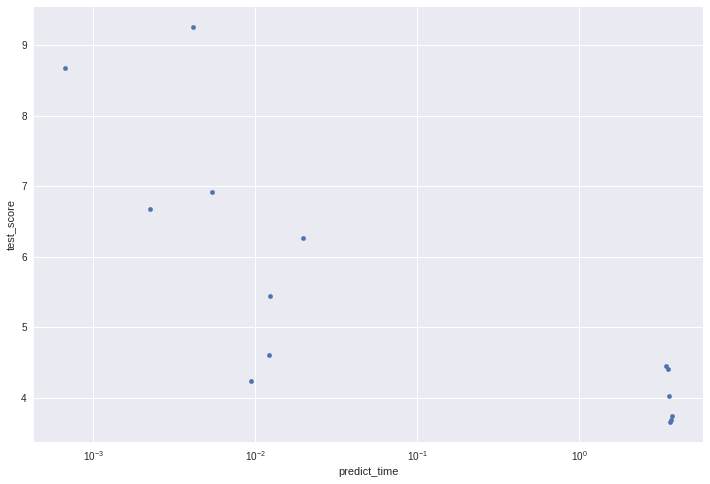

In [142]:
df.plot.scatter('predict_time', 'test_score', logx=True, figsize=(12, 8))

The Neural Network methods are more than two orders-of-magnitude slower than the scikit-learn methods, even the networks that perform similarly to RandomForest and SVM RBF. 

There is very little time difference between the smallest and largest neural networks, which suggest that there significant some constant-time overhead involved. Possibly this could be reduced by using the CPU for inference. 

# Kaggle submission

In [126]:
import subprocess

def make_submission(data, modelname, competition, submit=True):
  X_comp = scaler.transform(data[feature_columns])
  trained = results[modelname][6]
  Y_pred = trained.predict(X_comp)
  #print(X_comp.mean(axis=0), X_comp.std(axis=0))
  predictions = pandas.DataFrame({
      'ID': range(1, len(data)+1),
      'ConcreteCompressiveStrength': Y_pred,
  })
  print('means', predictions.ConcreteCompressiveStrength.mean(),
        dataset.ConcreteCompressiveStrength.mean())

  filename = 'pred_{}.csv'.format(modelname.replace(' ', '_'))
  predictions.to_csv(filename, index=False, columns=['ID', 'ConcreteCompressiveStrength'])
  
  if submit:
    args = [
        'kaggle', 'competitions', 'submit',
        '-c', competition,
        '-f', filename,
        '-m', 'bla'
    ]
    try:
      out = subprocess.check_output(args)
    except subprocess.CalledProcessError as e:
        print('error', e)
    print(out)
  
  return filename
  
competeset = pandas.read_csv('data/Concrete_test.csv')
make_submission(competeset, 'MLP 1024-512-256 Relu', 'dat300-2018-concrete')

means 37.26594 35.32181697919556
b'Successfully submitted to Concrete strength'


'pred_MLP_1024-512-256_Relu.csv'